# Whittaker smoother

This notebook gives examples on how to use the core whittaker smoothing functions directly on numpy arrays, as well as how they are chained together for smoothing MODIS NDVI products within wsmtk.

by Valentin Pesendorfer, December 2018

In [1]:
import os
import pickle
import datetime
import numpy as np
import array
import matplotlib.pyplot as plt
import wsmtk
from wsmtk.whittaker import ws2d, ws2d_vc, ws2d_vc_asy
from wsmtk.utils import DateHelper, fromjulian

In [2]:
# little plotting function

def plot(y,z=None,z_asy=None):
    plt.close()
    xax = [fromjulian(x) for x in dts]
    plt.figure(figsize=(15,8))
    plt.ylim(0,1)
    plt.plot(xax,y,label='y')

    try:
        plt.plot(xax,z,label='z')
    except ValueError:
        pass
    
    try:
        plt.plot(xax,z_asy,label='z_asy')
    except ValueError:
        pass
    
    plt.legend()
    plt.show()
    
   
    

### Load test data

The test data is a typical MOD/MYD interleaved 8-day timeseries. It's stored as float32 numpy array within a pickle file in the /data directory of the module. The values are already re-scaled to -1 to 1, with -3000 being the nodata value. This series does not contain nodata.



In [3]:
# timeseries and dates
with open(os.path.dirname(wsmtk.__file__) + '/data/MXD_test.pkl','rb') as pkl:
    y, dts = pickle.load(pkl)


### Plot raw timeseries

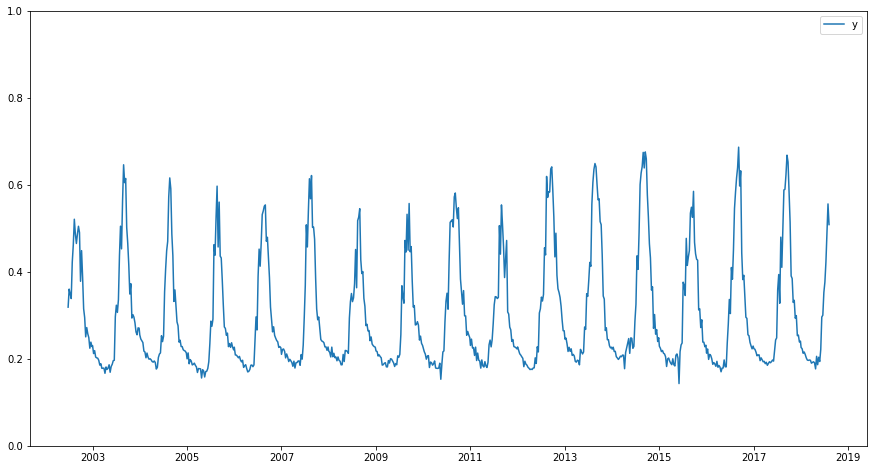

In [4]:
plot(y)

## Whittaker filter

The current implementation of the wsmtk module has three versions of the Whittaker filter:

 - `ws2d`: That's the basic Whittaker smoother with 2nd degree differences 
 - `ws2d_vc`: This is the Whittaker smoother with the V-curve optimization of the smoothing parameter. It builds on the previous one.
 - `ws2d_vc_asy`: Again the V-curve optimization, but with asymmetric weights as defined by a parameter (p).
 
 
  
_Implementational note:_

While these are the three basic versions, we currently use a "chain" of these to filter our NDVI products. This also takes care of the temporal interpolation. Following are exemples how to use them individually, and finally how we use them in our "smoothing chain".



### __`ws2d`__(y, l, w):


Arguments:

  * _`y`_ ... raw signal (1d float32 np array) 
  * _`l`_ ... smoothing parameter lambda (AKA _s_ in the module scrips) 
  * _`w`_ ... weights (float32 np array same len and dim as y) 

Returns:

array.array with smoothed signal

Notes:

The datatype float32 for both _`y`_ and _`w`_ is mandatory. The smoothing parameter is expected to be a float number. For missing data, set weight to 0 at the respective position, otherwhise 1.

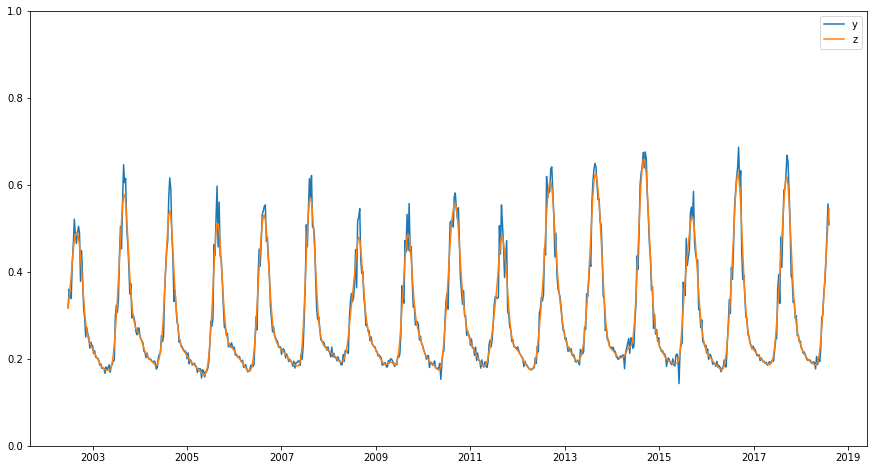

In [5]:
# create weights
w = np.array((y!=-3000)*1,dtype='float32')

# apply filter
z = ws2d(y,10,w)

plot(y,z)

del w

### __`ws2d_vc`__(y, w, llas) /  __`ws2d_vc_asy`__(y, w, llas, p):


Arguments:

  * _`y`_ ... see ws2d 
  * _`l`_ ... see ws2d
  * _`llas`_ ... range of lambda values for otimization (log10(l) values, needs to be float array.array) 
  * _`p`_ ... "envelope" value for asymmetric smoothing (only for ws2d_vc_asy, expected to be float number between 0 and 1)

Returns:

tuple with smoothed signal and optimum lambda (lOpt)

Notes:

Same applies as for ws2d. For lambda range, which is typically a sequence between minimum and maximum log10(lambda) with defined stepsize, the object needs to be an array.array with 'f' datatype.

lOpt for v-curve: 7.94 - lOpt for asymmetric V-curve: 2.0


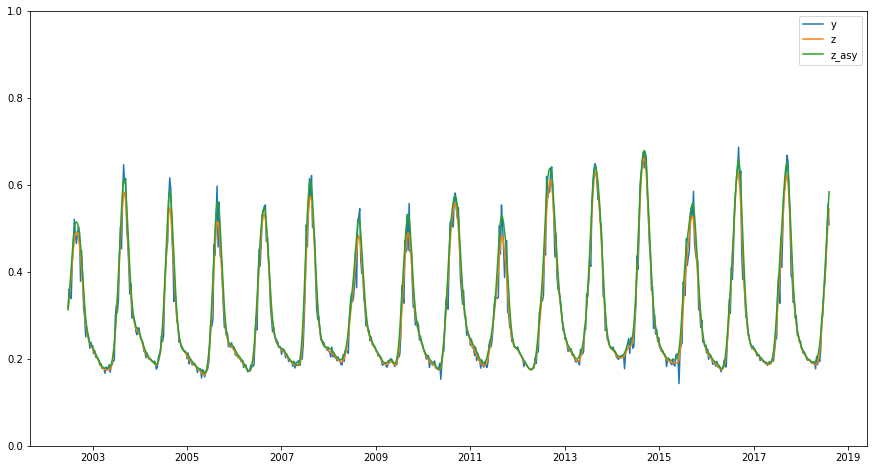

In [6]:
# create weights
w = np.array((y!=-3000)*1,dtype='float32')

lrange = array.array('f',np.linspace(-1,1,11))

# apply whittaker filter with V-curve
z_vc, lopt_vc = ws2d_vc(y,w,lrange)

# apply whittaker filter with V-curve and asymmetric smoothing
z_vc_asy, lopt_vc_asy = ws2d_vc_asy(y,w,lrange,p=0.9)

# check lOpt outputs (rounded for display)
print("lOpt for v-curve: {} - lOpt for asymmetric V-curve: {}".format(round(lopt_vc,2),round(lopt_vc_asy,2)))

plot(y,z_vc,z_vc_asy)

del w

### NDVI smoothing chain with (optional) temporal interpolation

In the current implementation of wsmtk, MODIS NDVI products are smoothed with the following chain of smoothing functions:

1. Derive first lOpt with V-curve optimization over initial lambda range
2. Limit the lambda range with using the previously derived lOpt as new upper bound
3. Run V-curve optimization with asymmetric smoothing (p = 0.90) and new constrained lambda range

 _optional if values are temoprally interpolated:_  
 &nbsp;
4. Fill smoothed values into an array that represents all daily values on the respecive acquisition dates
5. Create new weights array for daily values
6. Smooth daily array with basic Whittaker filter and very low lambda, which essentially only performs interpolation and no further smoothing
7. Select target dates of temporal interpolation from daily array

Note: 

For temporal interpolation, the smoothed raw observations are shifted to the midpoint of the compositing period (e.g. 16 day MODIS gets shifted by 8 days) 

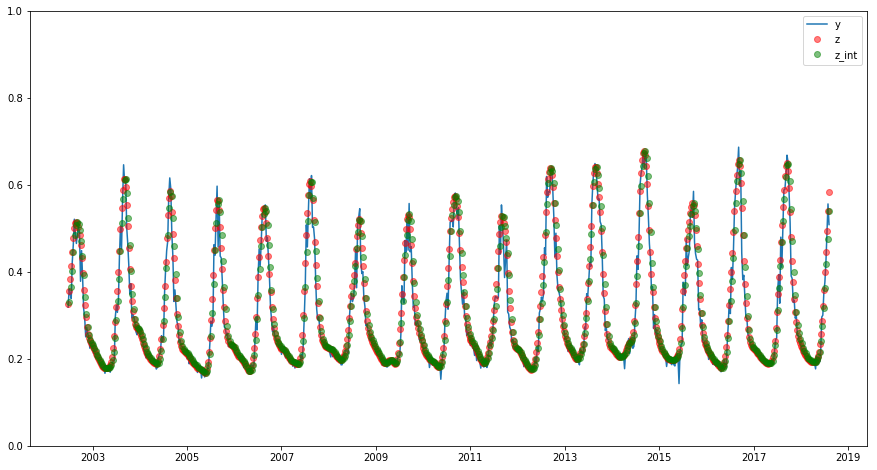

In [7]:
##### create weights
w = np.array((y!=-3000)*1,dtype='float32')

lrange = np.linspace(-1,1,11)

# apply whittaker filter with V-curve
z, lopt = ws2d_vc(y,w,array.array('f',lrange))

lrange_lim = lrange[lrange <= np.log10(lopt)]

# if only one value is left, we add one -0.2 below it
if len(lrange_lim)==1:
    lrange_lim = np.concatenate([lrange_lim-0.2,lrange_lim])

    
# run V-curve with limited lrange
z, lopt = ws2d_vc_asy(y,w,array.array('f',lrange_lim),p=0.90)


### Temporal interpolation

# little helper objects for managing dates (rtres = raw tem. resolution, stres = desired output temporal resolution)
dhelper = DateHelper(rawdates=dts, rtres=8, stres=10)

# daily vector
dvec = dhelper.getDV(nd=-3000)

# target date index 
dix = dhelper.getDIX()


# shift observations to midpoint of acquisition (these positions are set to 0 instead of nodata)
for d in dts:
    dvec[dhelper.daily.index((fromjulian(d) + datetime.timedelta(8)).strftime('%Y%j'))] = 0

dvec[ dvec != -3000 ] = z

w = np.array((dvec != -3000) * 1,dtype='float32')

dvec =  ws2d(dvec,0.0001,w)

z_int = np.array(dvec)[dix]

# plot

xax1 = [fromjulian(x) for x in dts]
xax2 = [fromjulian(x) for x in dhelper.target]

plt.close()
plt.figure(figsize=(15,8))
plt.ylim(0,1)
plt.plot(xax1,y, label='y')
plt.plot(xax1,z,'ro',label='z',alpha=0.5)
plt.plot(xax2,z_int,'go',label='z_int',alpha=0.5)
plt.legend()
plt.show()
